#Import Dataset from Kaggle

In [1]:
!pip install kaggle


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bayessensei","key":"f62e3ca565c7434ab849573c389c6451"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!ls ~/.kaggle

kaggle.json


In [5]:
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle datasets download -d arashnic/learn-time-series-forecasting-from-gold-price

  0% 0.00/48.6k [00:00<?, ?B/s]
100% 48.6k/48.6k [00:00<00:00, 50.8MB/s]


In [7]:
!unzip learn-time-series-forecasting-from-gold-price

Archive:  learn-time-series-forecasting-from-gold-price.zip
  inflating: gold_price_data.csv     


In [8]:
!ls

gold_price_data.csv  kaggle.json  learn-time-series-forecasting-from-gold-price.zip  sample_data


#Library

In [9]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,SGD
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import Callback

#Data Preprocessing

This data is about the price of gold from 1970 to 2020 in USD

In [10]:
data = pd.read_csv('/content/gold_price_data.csv')
data.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [11]:
data.isnull().sum()

Date     0
Value    0
dtype: int64

there is no missing value in data

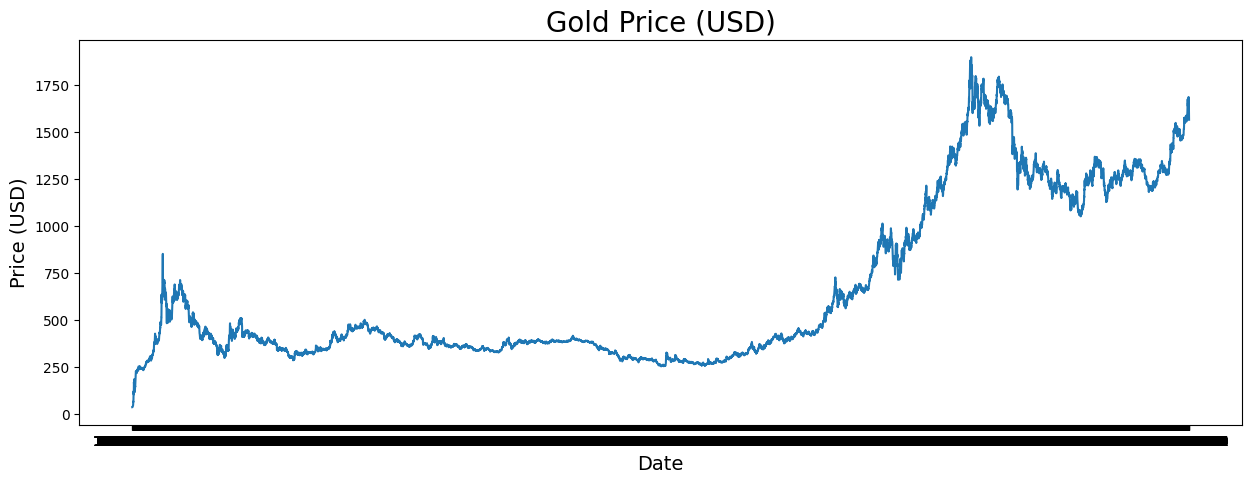

In [28]:
dates = data['Date'].values
price  = data['Value'].values.reshape(-1, 1)


plt.figure(figsize=(15,5))
plt.plot(dates, price)
plt.title('Gold Price (USD)',fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.show()

##Data Scaling

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [14]:
len(price_scaled)

10787

##Data Splitting

In [15]:
train_data, validation_data = train_test_split(price_scaled, test_size=0.2, shuffle=False)
len(train_data)


8629

In [16]:
len(validation_data)

2158

#Dataset Generation

In [17]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [18]:
time_step = 24
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(validation_data, time_step)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)


#Model

##Callback

Callback will stop the training when validation mean absolute erorr < 10% data scale

In [19]:
threshold_mae = (price_scaled.max() - price_scaled.min()) * 0.1
threshold_mae

0.1

In [20]:
class MyThresholdCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_mae') < threshold_mae):
            print("\nMAE telah mencapai kurang dari 10% skala data. Menghentikan pelatihan...")
            self.model.stop_training = True

# Menambahkan callback
callbacks = [MyThresholdCallback()]

##Model Architecture

In [21]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step,1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [22]:
optimizer = SGD(learning_rate=0.0001, momentum=0.5)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])


#Data Training

In [23]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, callbacks=[callbacks])

Epoch 1/200
269/269 [==============================] - 9s 10ms/step - loss: 0.0574 - mae: 0.1849 - val_loss: 0.3503 - val_mae: 0.5852
Epoch 2/200
269/269 [==============================] - 2s 8ms/step - loss: 0.0325 - mae: 0.1064 - val_loss: 0.2751 - val_mae: 0.5172
Epoch 3/200
269/269 [==============================] - 2s 8ms/step - loss: 0.0242 - mae: 0.0807 - val_loss: 0.2349 - val_mae: 0.4770
Epoch 4/200
269/269 [==============================] - 2s 8ms/step - loss: 0.0214 - mae: 0.0823 - val_loss: 0.2127 - val_mae: 0.4533
Epoch 5/200
269/269 [==============================] - 4s 16ms/step - loss: 0.0204 - mae: 0.0871 - val_loss: 0.1995 - val_mae: 0.4386
Epoch 6/200
269/269 [==============================] - 4s 14ms/step - loss: 0.0199 - mae: 0.0906 - val_loss: 0.1913 - val_mae: 0.4292
Epoch 7/200
269/269 [==============================] - 4s 16ms/step - loss: 0.0195 - mae: 0.0921 - val_loss: 0.1854 - val_mae: 0.4225
Epoch 8/200
269/269 [==============================] - 5s 17ms/st

#Result

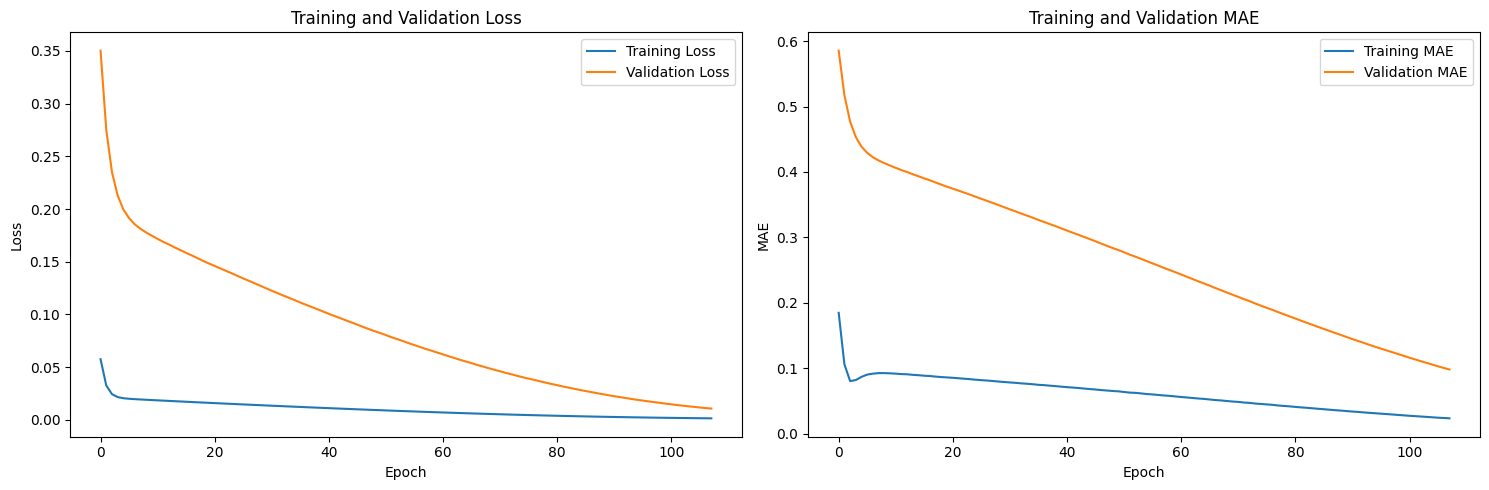

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

337/337 [==============================] - 1s 3ms/step


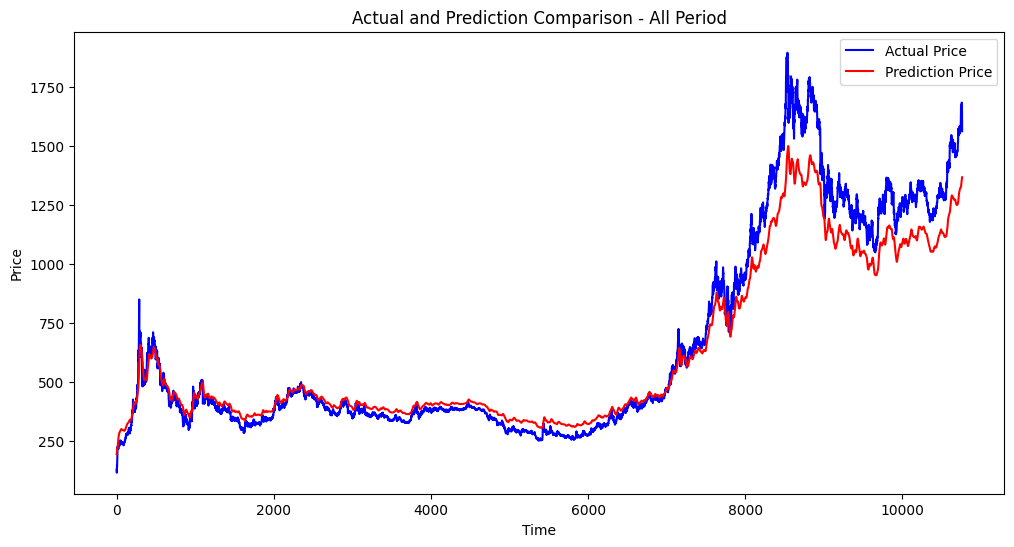

In [29]:
X_all, y_all = create_dataset(price_scaled, time_step)
X_all = X_all.reshape(X_all.shape[0], X_all.shape[1], 1)


predicted_all = model.predict(X_all)
predicted_all = scaler.inverse_transform(predicted_all)

actual_all = price[time_step+1:]

plt.figure(figsize=(12,6))
plt.plot(actual_all, label='Actual Price', color='blue')
plt.plot(predicted_all, label='Prediction Price', color='red')
plt.title('Actual and Prediction Comparison - All Period')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import mean_absolute_error

# Menghitung MAE
mae = mean_absolute_error(actual_all, predicted_all)
print("Mean Absolute Error: ", mae)


Mean Absolute Error:  71.95552671831263


In [27]:
threshold_mae_full = (price.max() - price.min()) * 0.1
print("Mean Absolute Error Threshold: ", threshold_mae_full)

Mean Absolute Error Threshold:  185.99
